In [1]:
import sys
sys.path.append('../../MembraneQuant')
from membranequant import *
%matplotlib notebook

In [2]:
path = ['/Users/blandt/Desktop/Data/PAR2 GFP linchpin/Experiment',
        '/Users/blandt/Desktop/Data/PAR2 GFP linchpin/N2']
paths = direcslist(path, 1)

imgs = [load_image(glob.glob(p + '/af_corrected.tif')[0]) for p in paths]
rois = [np.loadtxt(p + '/ROI_fit.txt') for p in paths]

cytbg = np.loadtxt('../Par2 GFP mutants 1/cytbg.txt')
membg = np.loadtxt('../Par2 GFP mutants 1/membg.txt')

In [3]:
iq = ImageQuant(img=imgs, roi=rois, descent_steps=350, rol_ave=5, 
                lr=0.01, iterations=1, cytbg=cytbg, membg=membg, uni_cyt=True, interp_type='linear')
iq.run()

100%|██████████| 350/350 [00:42<00:00,  8.16it/s]


Time elapsed: 44.20 seconds 


<IPython.core.display.Javascript object>


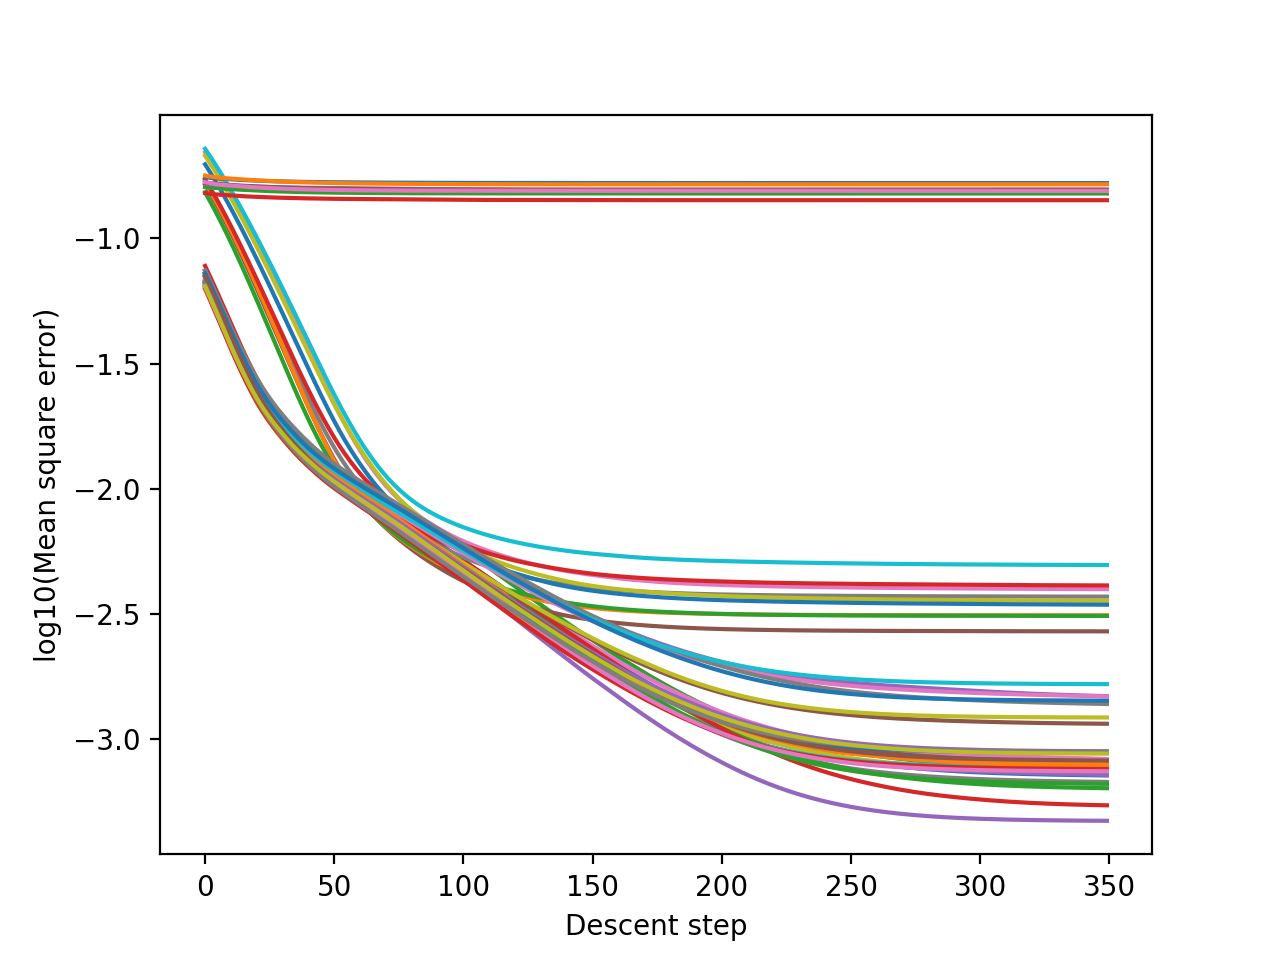

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

In [9]:
iq.plot_losses(log=True)

<IPython.core.display.Javascript object>


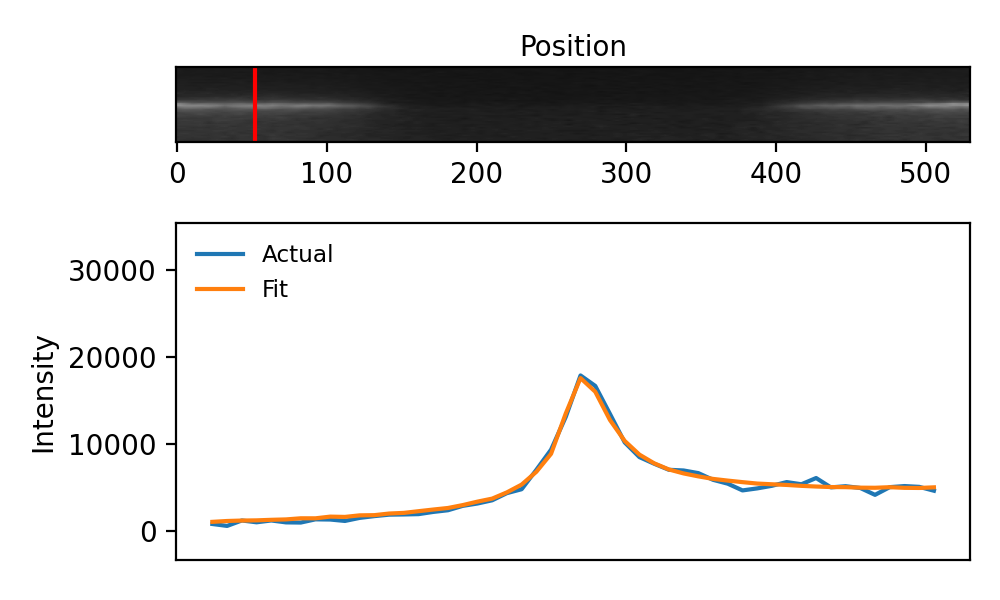

interactive(children=(IntSlider(value=0, description='Frame', max=46), FloatSlider(value=0.1, description='Pos…

(<Figure size 500x300 with 2 Axes>,
 (<AxesSubplot:xlabel='Position'>, <AxesSubplot:ylabel='Intensity'>))

In [10]:
iq.plot_fits(jupyter=True)

In [11]:
[np.savetxt(p + '/ROI_optimised.txt', r) for p, r in zip(paths, iq.roi)];

In [12]:
res = iq.compile_res()
res['Membrane signal'] = res['Membrane signal'] * 2.703889975912648
res.to_csv('res.csv')

In [13]:
res = pd.read_csv('res.csv')

conditions = [p.strip('/').split('/')[-2].split('_')[1] for p in paths]
mems_tot = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0, 1)))
mems_ant = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0.4, 0.6)))
mems_post = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0.9, 0.1)))
cyts = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Cytoplasmic signal'], (0, 1)))
ratios_tot = [m / c for m, c in zip(mems_tot, cyts)]
ratios_post = [m / c for m, c in zip(mems_post, cyts)]
dosages = [dosage(i, r, 5) for i, r in zip(imgs, rois)]

df_dict = {'Path': paths, 'Condition': conditions, 'Mem tot': mems_tot, 'Mem ant': mems_ant, 'Mem post': mems_post,
           'Cyt': cyts, 'Dosage': dosages, 'Ratio tot': ratios_tot, 'Ratio post': ratios_post}
df = pd.DataFrame(df_dict)
df.to_csv('df.csv')